In [ ]:
!pip install pdf2image jinja2 amazon-textract-textractor
!apt-get update
! apt-get install -y poppler-utils

## In this notebook, we demostrate the power of Multi-Modal generative AI to extract key information from Bill of Lading documents. 
We'll do the following
1. Extract the text of the document through Textract
2. Create a prompt, including the text of the document as context for the model
3. Push the prompt, along with images of the document pages to Claude Haiku, and see the response

In [61]:
import boto3
import json
import matplotlib.pyplot as plt
import io
from textractor import Textractor
from utils import parse_response, convert_image_to_bytes, render_payload, convert_pdf_to_images, get_jinja_env
import base64
from textractor.parsers import response_parser

env = get_jinja_env()

client = boto3.client("textract")
bedrock = boto3.client(
     service_name='bedrock-runtime',
     region_name='us-west-2'
)

def get_bytes(loc):
    image = convert_pdf_to_images(loc)[0]
    img_byte_arr = io.BytesIO()
    image.save(img_byte_arr, format='PNG')
    return img_byte_arr.getvalue()
    
    
def send_example_to_textract(loc):
    bts = get_bytes(loc)
    result = client.detect_document_text(
        Document = {"Bytes": bts})
    return result

# Let's take a look at our doc. 

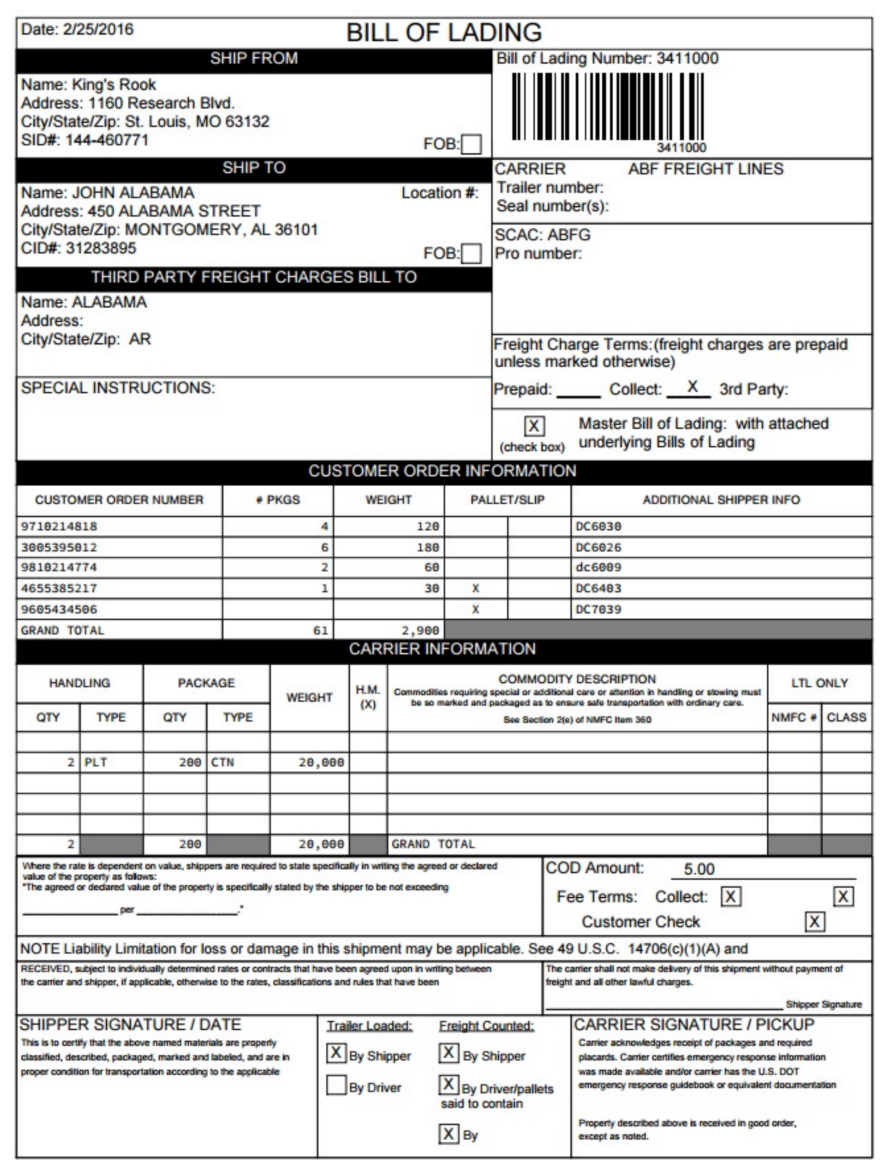

In [92]:
doc_loc = "data/wao/bol2.pdf"

images = convert_pdf_to_images(doc_loc)
fig, ax = plt.subplots(figsize = (20, 15))

_ = ax.imshow(images[0])
_ = ax.axis("off")

# Now, let's process our document to be Claude ready
1. We're going to run the doc through textract so we can add the text signal to Claude. Claude can read the text on the page, but for double additioanl signal, we add in the words from the doc to our prompt set. 
2. We convert this PDF to bytes so we can send it to claude in our payload. 

In [84]:
# Send the doc to textract and get the doc as a textractor document
result = send_example_to_textract(doc_loc)
doc = response_parser.parse(result)

In [76]:
#2 Convert doc to bytes
images = convert_pdf_to_images(doc_loc)
img_bytes = [convert_image_to_bytes(i) for i in images]

# Now, let's take a look at our prompt!
Wow, what a nice prompt! did that take you hours to write? Nope! Claude wrote it for me!
What??!? Claude writes its own prompts for structured extraction? Yep, sure does. 

I'm also using Jinja templating here to make sure our prompt is really concise, and easy to operate, note that I can pass in pages as additional signal. 

In [85]:
template = env.get_template("bol_template.txt")

print(template.render(pages = [" ".join([l.text for l in doc.lines])]))


You are an assistant that helps perform tasks on documents. 
You have received document pages in order of read. You are to perform the task defined below. 
Do not return anything except what is asked for in the task. 

<task>

You will be provided with an image of a Bill of Lading document. Your task is to extract the relevant information from the document and return it as structured data in JSON format with the following structure and keys in snake_case:

{
  "ship_from": {
    "name": "The name of the company or entity shipping the goods",
    "address": "The street address of the shipping location",
    "city": "The city of the shipping location", 
    "state": "The state of the shipping location",
    "zip": "The zip or postal code of the shipping location"
  },
  "ship_to": {
    "name": "The name of the company or entity receiving the goods",
    "address": "The street address of the destination location",
    "city": "The city of the destination location",
    "state": "The sta

# Finally, let's set up our invoaction to Claude
I'm going to set temp to zero so there's very little improvization here. 
Next, we put in system promnpt, and we pass our configuration, the image, and the prompt to our model. From there we invoke, and we get back the response, which we see below. 

In [86]:
model_id = "anthropic.claude-3-haiku-20240307-v1:0"
claude_config = {
    'max_tokens': 100000,
    'temperature': 0,
    'anthropic_version': 'bedrock-2023-05-31',
    'top_p': 0.999,
    'stop_sequences': ['Human:']
}

In [87]:
system_prompt = 'you are an AI data assistant supporting data entry tasks'
body = render_payload(img_bytes[0:1], template.render(), system_prompt, claude_config = claude_config)

In [88]:
response = bedrock.invoke_model(
    modelId=model_id,
    body=json.dumps(body))

In [89]:
result = parse_response(response)
print(result)

{
  "ship_from": {
    "name": "King's Rook",
    "address": "1160 Research Blvd.",
    "city": "St. Louis",
    "state": "MO",
    "zip": "63132"
  },
  "ship_to": {
    "name": "JOHN ALABAMA",
    "address": "450 ALABAMA STREET",
    "city": "MONTGOMERY",
    "state": "AL",
    "zip": "36101"
  },
  "third_party_freight_charges_bill_to": {
    "name": "ALABAMA",
    "address": "",
    "city": "AR",
    "state": "AR",
    "zip": "AR"
  },
  "carrier": "ABF FREIGHT LINES",
  "trailer_number": "",
  "seal_number": "",
  "scac": "ABFG",
  "pro_number": "",
  "customer_order_numbers": [
    {
      "order_number": "9718214818",
      "packages": 4,
      "weight": 128,
      "pallets_or_slips": [
        {
          "number": "X",
          "additional_shipper_info": "DC6638"
        }
      ]
    },
    {
      "order_number": "3065395812",
      "packages": 6,
      "weight": 180,
      "pallets_or_slips": [
        {
          "number": "X",
          "additional_shipper_info": "DC6626